In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animal-image-dataset-90-different-animals/name of the animals.txt
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/687486f1cb.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/93fb82b04b.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/7d7f6c9750.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/0de750893f.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/2fecd5e844.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/514cd025fa.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/44931701fe.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/138f5c986e.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/9977af1a6f.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/be

In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import cv2 
##from google.colab.patches import cv2_imshow
from PIL import Image
import sys
import math
import random
from skimage.transform import rotate, AffineTransform
from skimage.util import random_noise

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from torch.utils.data import TensorDataset, ConcatDataset
import random
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim

In [3]:
# this cell is regarding the aumentation and normalization with the stats of data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2)),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),
    # transforms.RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
dataset = datasets.ImageFolder("/kaggle/input/animal-image-dataset-90-different-animals/animals/animals", transform= transform)

In [5]:
# this cell is spliting dataset to train and test
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
test_split = 0.2
dataset_size = len(dataset)
test_size = int(test_split * dataset_size)
train_size = dataset_size - test_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [6]:
# this cell is spliting train to train and val
val_split = 0.2
train_size = len(train_dataset)
val_size = int(val_split * train_size)
train_size = train_size - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [7]:
# Define the data loaders for the train and test sets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle= True,
                          drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle= True,
                        drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle= True,
                         drop_last=True)

In [8]:
num_class = len(dataset.classes)

In [9]:
print(num_class)

90


# Finetune resnet 18

In [10]:
# Define the ResNet18 model
model = torchvision.models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_class)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(DEVICE)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [12]:
# Train phase
from tqdm import tqdm

# Define the number of epochs
num_epochs = 50
loss_train = []
loss_val = []
loss_test = []

accuracy_train = []
accuracy_val = []
accuracy_test = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss_train = 0.0
    correct_train = 0
    total_train = 0
    running_loss_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # loss
        running_loss_train += loss.item()
        # accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
    accuracy = 100 * correct_train / total_train
    loss_train.append(running_loss_train/len(train_loader))
    accuracy_train.append(accuracy)
    print(f"Accuracy of the network on the train images after {epoch + 1} epochs is: {accuracy}")

    # Evaluate the model on validation
    model.eval()
    correct_val = 0
    total_val = 0
    running_loss_val = 0
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs, val_labels = val_data
            val_inputs = val_inputs.to(DEVICE)
            val_labels = val_labels.to(DEVICE)
            # loss
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            running_loss_val += loss.item()
            # accuracy
            _, predicted_val = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()
    accuracy = 100 * correct_val / total_val
    loss_val.append(running_loss_val/len(val_loader))        
    accuracy_val.append(accuracy)
    print(f"Accuracy of the network on the val images after {epoch + 1} epochs is: {accuracy}")

    # Evaluate the model on test
    model.eval()
    correct_test = 0
    total_test = 0
    running_loss_test = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(val_outputs, val_labels)
            running_loss_test += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    accuracy = 100 * correct_test / total_test
    loss_test.append(running_loss_test/len(test_loader)) 
    accuracy_test.append(accuracy)
    print(f"Accuracy of the network on the test images after {epoch + 1} epochs is: {accuracy}")
    print('------------------------')

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy of the network on the train images after 1 epochs is: 1.3310185185185186
Accuracy of the network on the val images after 1 epochs is: 0.9114583333333334


  2%|▏         | 1/50 [02:27<2:00:38, 147.72s/it]

Accuracy of the network on the test images after 1 epochs is: 0.87890625
------------------------
Accuracy of the network on the train images after 2 epochs is: 1.880787037037037
Accuracy of the network on the val images after 2 epochs is: 2.0833333333333335


  4%|▍         | 2/50 [04:31<1:46:45, 133.45s/it]

Accuracy of the network on the test images after 2 epochs is: 2.63671875
------------------------
Accuracy of the network on the train images after 3 epochs is: 3.6458333333333335
Accuracy of the network on the val images after 3 epochs is: 3.125


  6%|▌         | 3/50 [06:32<1:40:21, 128.11s/it]

Accuracy of the network on the test images after 3 epochs is: 4.8828125
------------------------
Accuracy of the network on the train images after 4 epochs is: 4.6875
Accuracy of the network on the val images after 4 epochs is: 4.6875


  8%|▊         | 4/50 [08:34<1:36:06, 125.36s/it]

Accuracy of the network on the test images after 4 epochs is: 4.00390625
------------------------
Accuracy of the network on the train images after 5 epochs is: 5.324074074074074
Accuracy of the network on the val images after 5 epochs is: 5.598958333333333


 10%|█         | 5/50 [10:36<1:33:06, 124.15s/it]

Accuracy of the network on the test images after 5 epochs is: 5.95703125
------------------------
Accuracy of the network on the train images after 6 epochs is: 6.394675925925926
Accuracy of the network on the val images after 6 epochs is: 6.25


 12%|█▏        | 6/50 [12:37<1:30:22, 123.23s/it]

Accuracy of the network on the test images after 6 epochs is: 6.73828125
------------------------
Accuracy of the network on the train images after 7 epochs is: 7.494212962962963
Accuracy of the network on the val images after 7 epochs is: 8.463541666666666


 14%|█▍        | 7/50 [14:41<1:28:26, 123.40s/it]

Accuracy of the network on the test images after 7 epochs is: 7.71484375
------------------------
Accuracy of the network on the train images after 8 epochs is: 8.043981481481481
Accuracy of the network on the val images after 8 epochs is: 6.510416666666667


 16%|█▌        | 8/50 [16:44<1:26:17, 123.27s/it]

Accuracy of the network on the test images after 8 epochs is: 7.421875
------------------------
Accuracy of the network on the train images after 9 epochs is: 8.449074074074074
Accuracy of the network on the val images after 9 epochs is: 9.114583333333334


 18%|█▊        | 9/50 [18:47<1:24:13, 123.27s/it]

Accuracy of the network on the test images after 9 epochs is: 8.7890625
------------------------
Accuracy of the network on the train images after 10 epochs is: 8.825231481481481
Accuracy of the network on the val images after 10 epochs is: 7.682291666666667


 20%|██        | 10/50 [20:51<1:22:18, 123.46s/it]

Accuracy of the network on the test images after 10 epochs is: 7.421875
------------------------
Accuracy of the network on the train images after 11 epochs is: 9.288194444444445
Accuracy of the network on the val images after 11 epochs is: 7.552083333333333


 22%|██▏       | 11/50 [22:54<1:20:14, 123.45s/it]

Accuracy of the network on the test images after 11 epochs is: 6.73828125
------------------------
Accuracy of the network on the train images after 12 epochs is: 10.09837962962963
Accuracy of the network on the val images after 12 epochs is: 9.505208333333334


 24%|██▍       | 12/50 [24:57<1:17:58, 123.12s/it]

Accuracy of the network on the test images after 12 epochs is: 8.3984375
------------------------
Accuracy of the network on the train images after 13 epochs is: 11.574074074074074
Accuracy of the network on the val images after 13 epochs is: 8.854166666666666


 26%|██▌       | 13/50 [27:00<1:15:56, 123.14s/it]

Accuracy of the network on the test images after 13 epochs is: 8.10546875
------------------------
Accuracy of the network on the train images after 14 epochs is: 12.210648148148149
Accuracy of the network on the val images after 14 epochs is: 10.416666666666666


 28%|██▊       | 14/50 [29:05<1:14:10, 123.63s/it]

Accuracy of the network on the test images after 14 epochs is: 10.44921875
------------------------
Accuracy of the network on the train images after 15 epochs is: 13.10763888888889
Accuracy of the network on the val images after 15 epochs is: 9.765625


 30%|███       | 15/50 [31:10<1:12:26, 124.18s/it]

Accuracy of the network on the test images after 15 epochs is: 10.546875
------------------------
Accuracy of the network on the train images after 16 epochs is: 12.760416666666666
Accuracy of the network on the val images after 16 epochs is: 10.807291666666666


 32%|███▏      | 16/50 [33:17<1:10:51, 125.05s/it]

Accuracy of the network on the test images after 16 epochs is: 11.03515625
------------------------
Accuracy of the network on the train images after 17 epochs is: 13.744212962962964
Accuracy of the network on the val images after 17 epochs is: 11.848958333333334


 34%|███▍      | 17/50 [35:22<1:08:47, 125.08s/it]

Accuracy of the network on the test images after 17 epochs is: 10.64453125
------------------------
Accuracy of the network on the train images after 18 epochs is: 15.075231481481481
Accuracy of the network on the val images after 18 epochs is: 14.973958333333334


 36%|███▌      | 18/50 [37:28<1:06:45, 125.18s/it]

Accuracy of the network on the test images after 18 epochs is: 12.20703125
------------------------
Accuracy of the network on the train images after 19 epochs is: 16.52199074074074
Accuracy of the network on the val images after 19 epochs is: 11.979166666666666


 38%|███▊      | 19/50 [39:31<1:04:18, 124.46s/it]

Accuracy of the network on the test images after 19 epochs is: 13.18359375
------------------------
Accuracy of the network on the train images after 20 epochs is: 16.984953703703702
Accuracy of the network on the val images after 20 epochs is: 13.671875


 40%|████      | 20/50 [41:35<1:02:17, 124.57s/it]

Accuracy of the network on the test images after 20 epochs is: 12.98828125
------------------------
Accuracy of the network on the train images after 21 epochs is: 19.010416666666668
Accuracy of the network on the val images after 21 epochs is: 12.890625


 42%|████▏     | 21/50 [43:41<1:00:18, 124.76s/it]

Accuracy of the network on the test images after 21 epochs is: 13.76953125
------------------------
Accuracy of the network on the train images after 22 epochs is: 19.87847222222222
Accuracy of the network on the val images after 22 epochs is: 11.71875


 44%|████▍     | 22/50 [45:45<58:13, 124.77s/it]  

Accuracy of the network on the test images after 22 epochs is: 12.59765625
------------------------
Accuracy of the network on the train images after 23 epochs is: 21.15162037037037
Accuracy of the network on the val images after 23 epochs is: 12.369791666666666


 46%|████▌     | 23/50 [47:49<55:58, 124.37s/it]

Accuracy of the network on the test images after 23 epochs is: 12.890625
------------------------
Accuracy of the network on the train images after 24 epochs is: 21.38310185185185
Accuracy of the network on the val images after 24 epochs is: 14.973958333333334


 48%|████▊     | 24/50 [49:53<53:53, 124.36s/it]

Accuracy of the network on the test images after 24 epochs is: 15.72265625
------------------------
Accuracy of the network on the train images after 25 epochs is: 23.78472222222222
Accuracy of the network on the val images after 25 epochs is: 15.104166666666666


 50%|█████     | 25/50 [51:57<51:48, 124.36s/it]

Accuracy of the network on the test images after 25 epochs is: 14.2578125
------------------------
Accuracy of the network on the train images after 26 epochs is: 25.0
Accuracy of the network on the val images after 26 epochs is: 16.927083333333332


 52%|█████▏    | 26/50 [54:03<49:54, 124.78s/it]

Accuracy of the network on the test images after 26 epochs is: 16.30859375
------------------------
Accuracy of the network on the train images after 27 epochs is: 26.475694444444443
Accuracy of the network on the val images after 27 epochs is: 16.40625


 54%|█████▍    | 27/50 [56:08<47:50, 124.81s/it]

Accuracy of the network on the test images after 27 epochs is: 17.7734375
------------------------
Accuracy of the network on the train images after 28 epochs is: 27.05439814814815
Accuracy of the network on the val images after 28 epochs is: 15.755208333333334


 56%|█████▌    | 28/50 [58:12<45:42, 124.64s/it]

Accuracy of the network on the test images after 28 epochs is: 18.45703125
------------------------
Accuracy of the network on the train images after 29 epochs is: 28.67476851851852
Accuracy of the network on the val images after 29 epochs is: 14.973958333333334


 58%|█████▊    | 29/50 [1:00:17<43:37, 124.66s/it]

Accuracy of the network on the test images after 29 epochs is: 14.55078125
------------------------
Accuracy of the network on the train images after 30 epochs is: 30.70023148148148
Accuracy of the network on the val images after 30 epochs is: 17.447916666666668


 60%|██████    | 30/50 [1:02:21<41:31, 124.58s/it]

Accuracy of the network on the test images after 30 epochs is: 18.84765625
------------------------
Accuracy of the network on the train images after 31 epochs is: 31.79976851851852
Accuracy of the network on the val images after 31 epochs is: 14.84375


 62%|██████▏   | 31/50 [1:04:25<39:23, 124.38s/it]

Accuracy of the network on the test images after 31 epochs is: 15.625
------------------------
Accuracy of the network on the train images after 32 epochs is: 33.0150462962963
Accuracy of the network on the val images after 32 epochs is: 18.489583333333332


 64%|██████▍   | 32/50 [1:06:31<37:23, 124.63s/it]

Accuracy of the network on the test images after 32 epochs is: 19.921875
------------------------
Accuracy of the network on the train images after 33 epochs is: 35.098379629629626
Accuracy of the network on the val images after 33 epochs is: 15.755208333333334


 66%|██████▌   | 33/50 [1:08:34<35:10, 124.17s/it]

Accuracy of the network on the test images after 33 epochs is: 16.2109375
------------------------
Accuracy of the network on the train images after 34 epochs is: 36.80555555555556
Accuracy of the network on the val images after 34 epochs is: 18.229166666666668


 68%|██████▊   | 34/50 [1:10:38<33:08, 124.29s/it]

Accuracy of the network on the test images after 34 epochs is: 20.01953125
------------------------
Accuracy of the network on the train images after 35 epochs is: 38.31018518518518
Accuracy of the network on the val images after 35 epochs is: 20.833333333333332


 70%|███████   | 35/50 [1:12:41<30:58, 123.89s/it]

Accuracy of the network on the test images after 35 epochs is: 17.48046875
------------------------
Accuracy of the network on the train images after 36 epochs is: 39.988425925925924
Accuracy of the network on the val images after 36 epochs is: 22.916666666666668


 72%|███████▏  | 36/50 [1:14:44<28:51, 123.69s/it]

Accuracy of the network on the test images after 36 epochs is: 21.77734375
------------------------
Accuracy of the network on the train images after 37 epochs is: 43.43171296296296
Accuracy of the network on the val images after 37 epochs is: 20.703125


 74%|███████▍  | 37/50 [1:16:49<26:49, 123.81s/it]

Accuracy of the network on the test images after 37 epochs is: 19.62890625
------------------------
Accuracy of the network on the train images after 38 epochs is: 44.589120370370374
Accuracy of the network on the val images after 38 epochs is: 23.307291666666668


 76%|███████▌  | 38/50 [1:18:52<24:45, 123.82s/it]

Accuracy of the network on the test images after 38 epochs is: 24.51171875
------------------------
Accuracy of the network on the train images after 39 epochs is: 45.254629629629626
Accuracy of the network on the val images after 39 epochs is: 20.833333333333332


 78%|███████▊  | 39/50 [1:20:55<22:39, 123.60s/it]

Accuracy of the network on the test images after 39 epochs is: 21.6796875
------------------------
Accuracy of the network on the train images after 40 epochs is: 47.74305555555556
Accuracy of the network on the val images after 40 epochs is: 22.786458333333332


 80%|████████  | 40/50 [1:23:01<20:41, 124.18s/it]

Accuracy of the network on the test images after 40 epochs is: 22.8515625
------------------------
Accuracy of the network on the train images after 41 epochs is: 50.9837962962963
Accuracy of the network on the val images after 41 epochs is: 22.395833333333332


 82%|████████▏ | 41/50 [1:25:07<18:42, 124.68s/it]

Accuracy of the network on the test images after 41 epochs is: 24.51171875
------------------------
Accuracy of the network on the train images after 42 epochs is: 53.24074074074074
Accuracy of the network on the val images after 42 epochs is: 23.177083333333332


 84%|████████▍ | 42/50 [1:27:12<16:38, 124.77s/it]

Accuracy of the network on the test images after 42 epochs is: 22.4609375
------------------------
Accuracy of the network on the train images after 43 epochs is: 55.324074074074076
Accuracy of the network on the val images after 43 epochs is: 27.083333333333332


 86%|████████▌ | 43/50 [1:29:17<14:34, 124.90s/it]

Accuracy of the network on the test images after 43 epochs is: 26.3671875
------------------------
Accuracy of the network on the train images after 44 epochs is: 55.989583333333336
Accuracy of the network on the val images after 44 epochs is: 27.083333333333332


 88%|████████▊ | 44/50 [1:31:22<12:29, 124.91s/it]

Accuracy of the network on the test images after 44 epochs is: 24.70703125
------------------------
Accuracy of the network on the train images after 45 epochs is: 57.72569444444444
Accuracy of the network on the val images after 45 epochs is: 26.953125


 90%|█████████ | 45/50 [1:33:26<10:23, 124.77s/it]

Accuracy of the network on the test images after 45 epochs is: 23.92578125
------------------------
Accuracy of the network on the train images after 46 epochs is: 61.60300925925926
Accuracy of the network on the val images after 46 epochs is: 30.989583333333332


 92%|█████████▏| 46/50 [1:35:31<08:19, 124.80s/it]

Accuracy of the network on the test images after 46 epochs is: 27.34375
------------------------
Accuracy of the network on the train images after 47 epochs is: 61.226851851851855
Accuracy of the network on the val images after 47 epochs is: 29.036458333333332


 94%|█████████▍| 47/50 [1:37:37<06:15, 125.10s/it]

Accuracy of the network on the test images after 47 epochs is: 27.24609375
------------------------
Accuracy of the network on the train images after 48 epochs is: 66.11689814814815
Accuracy of the network on the val images after 48 epochs is: 30.338541666666668


 96%|█████████▌| 48/50 [1:39:43<04:10, 125.27s/it]

Accuracy of the network on the test images after 48 epochs is: 29.1015625
------------------------
Accuracy of the network on the train images after 49 epochs is: 66.69560185185185
Accuracy of the network on the val images after 49 epochs is: 31.25


 98%|█████████▊| 49/50 [1:41:47<02:05, 125.10s/it]

Accuracy of the network on the test images after 49 epochs is: 31.0546875
------------------------
Accuracy of the network on the train images after 50 epochs is: 68.72106481481481
Accuracy of the network on the val images after 50 epochs is: 31.901041666666668


100%|██████████| 50/50 [1:43:53<00:00, 124.66s/it]

Accuracy of the network on the test images after 50 epochs is: 28.22265625
------------------------


In [16]:
#save the path
model_save_name = 'resnet18.pt'
path = f"/kaggle/working/{model_save_name}" 
torch.save(model.state_dict(), path)

Text(0, 0.5, 'loss')

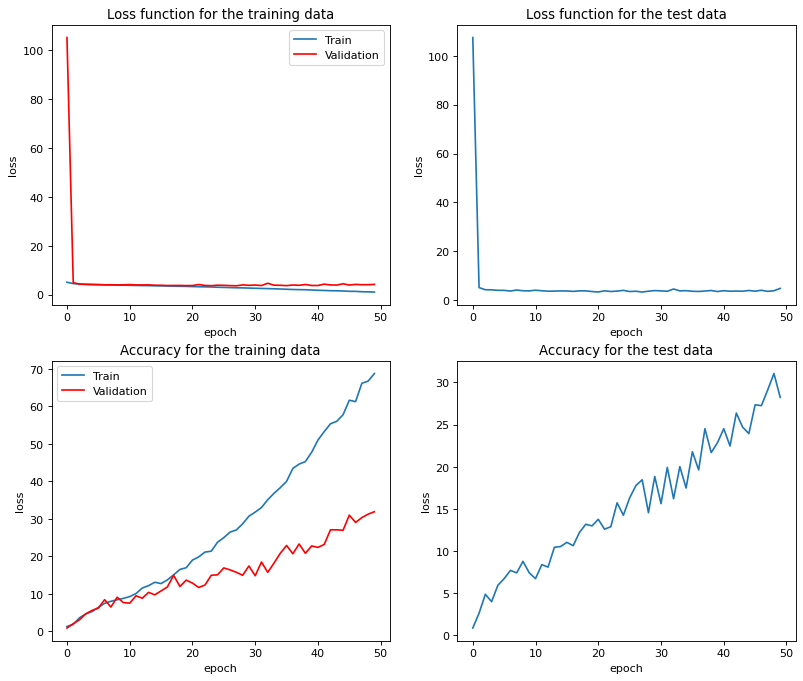

In [17]:
# plot train and val and test accuracy 
plt.figure(figsize=(12,10), dpi=80)

plt.subplot(2, 2, 1)
plt.plot(loss_train, label="Train")
plt.plot(loss_val, color='red', label="Validation")
plt.title('Loss function for the training data')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(loss_test)
plt.title('Loss function for the test data')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2, 2, 3)
plt.plot(accuracy_train, label="Train")
plt.plot(accuracy_val, color='red', label="Validation")
plt.title('Accuracy for the training data')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(accuracy_test)
plt.title('Accuracy for the test data')
plt.xlabel('epoch')
plt.ylabel('loss')

In [19]:
# save accuracy and loss
import pickle
with open("/kaggle/working/accuracy_resnet18.txt", "wb") as fp:
    pickle.dump(accuracy_train, fp)
    pickle.dump(accuracy_val, fp)
    pickle.dump(accuracy_test, fp)

with open("/kaggle/working/loss_resnet18.txt", "wb") as fp:
    pickle.dump(loss_train, fp)
    pickle.dump(loss_val, fp)
    pickle.dump(loss_test, fp)

# ShuffleNet V2

In [20]:
# Define the ShuflleNetV2 model
model = torchvision.models.shufflenet_v2_x1_0(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 90)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(DEVICE)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [22]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [24]:
# Train phase
from tqdm import tqdm

# Define the number of epochs
num_epochs = 50
loss_train = []
loss_val = []
loss_test = []

accuracy_train = []
accuracy_val = []
accuracy_test = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss_train = 0.0
    correct_train = 0
    total_train = 0
    running_loss_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # loss
        running_loss_train += loss.item()
        # accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
    accuracy = 100 * correct_train / total_train
    loss_train.append(running_loss_train/len(train_loader))
    accuracy_train.append(accuracy)
    print(f"Accuracy of the network on the train images after {epoch + 1} epochs is: {accuracy}")

    # Evaluate the model on validation
    model.eval()
    correct_val = 0
    total_val = 0
    running_loss_val = 0
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs, val_labels = val_data
            val_inputs = val_inputs.to(DEVICE)
            val_labels = val_labels.to(DEVICE)
            # loss
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            running_loss_val += loss.item()
            # accuracy
            _, predicted_val = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()
    accuracy = 100 * correct_val / total_val
    loss_val.append(running_loss_val/len(val_loader))        
    accuracy_val.append(accuracy)
    print(f"Accuracy of the network on the val images after {epoch + 1} epochs is: {accuracy}")

    # Evaluate the model on test
    model.eval()
    correct_test = 0
    total_test = 0
    running_loss_test = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(val_outputs, val_labels)
            running_loss_test += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    accuracy = 100 * correct_test / total_test
    loss_test.append(running_loss_test/len(test_loader)) 
    accuracy_test.append(accuracy)
    print(f"Accuracy of the network on the test images after {epoch + 1} epochs is: {accuracy}")
    print('------------------------')

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy of the network on the train images after 1 epochs is: 1.1863425925925926
Accuracy of the network on the val images after 1 epochs is: 0.9114583333333334


  2%|▏         | 1/50 [02:09<1:45:49, 129.59s/it]

Accuracy of the network on the test images after 1 epochs is: 0.9765625
------------------------
Accuracy of the network on the train images after 2 epochs is: 1.2152777777777777
Accuracy of the network on the val images after 2 epochs is: 1.0416666666666667


  4%|▍         | 2/50 [04:16<1:42:18, 127.88s/it]

Accuracy of the network on the test images after 2 epochs is: 0.9765625
------------------------
Accuracy of the network on the train images after 3 epochs is: 1.9097222222222223
Accuracy of the network on the val images after 3 epochs is: 1.0416666666666667


  6%|▌         | 3/50 [06:22<1:39:44, 127.32s/it]

Accuracy of the network on the test images after 3 epochs is: 1.85546875
------------------------
Accuracy of the network on the train images after 4 epochs is: 1.4756944444444444
Accuracy of the network on the val images after 4 epochs is: 2.2135416666666665


  8%|▊         | 4/50 [08:28<1:37:09, 126.72s/it]

Accuracy of the network on the test images after 4 epochs is: 1.85546875
------------------------
Accuracy of the network on the train images after 5 epochs is: 2.372685185185185
Accuracy of the network on the val images after 5 epochs is: 3.515625


 10%|█         | 5/50 [10:35<1:35:01, 126.71s/it]

Accuracy of the network on the test images after 5 epochs is: 2.734375
------------------------
Accuracy of the network on the train images after 6 epochs is: 2.517361111111111
Accuracy of the network on the val images after 6 epochs is: 2.6041666666666665


 12%|█▏        | 6/50 [12:42<1:32:54, 126.68s/it]

Accuracy of the network on the test images after 6 epochs is: 2.734375
------------------------
Accuracy of the network on the train images after 7 epochs is: 4.0219907407407405
Accuracy of the network on the val images after 7 epochs is: 3.90625


 14%|█▍        | 7/50 [14:48<1:30:45, 126.65s/it]

Accuracy of the network on the test images after 7 epochs is: 3.515625
------------------------
Accuracy of the network on the train images after 8 epochs is: 4.427083333333333
Accuracy of the network on the val images after 8 epochs is: 4.036458333333333


 16%|█▌        | 8/50 [16:54<1:28:31, 126.46s/it]

Accuracy of the network on the test images after 8 epochs is: 3.125
------------------------
Accuracy of the network on the train images after 9 epochs is: 5.295138888888889
Accuracy of the network on the val images after 9 epochs is: 3.125


 18%|█▊        | 9/50 [18:59<1:26:08, 126.06s/it]

Accuracy of the network on the test images after 9 epochs is: 3.90625
------------------------
Accuracy of the network on the train images after 10 epochs is: 6.163194444444445
Accuracy of the network on the val images after 10 epochs is: 5.989583333333333


 20%|██        | 10/50 [21:06<1:24:12, 126.30s/it]

Accuracy of the network on the test images after 10 epochs is: 5.46875
------------------------
Accuracy of the network on the train images after 11 epochs is: 7.175925925925926
Accuracy of the network on the val images after 11 epochs is: 7.161458333333333


 22%|██▏       | 11/50 [23:14<1:22:18, 126.63s/it]

Accuracy of the network on the test images after 11 epochs is: 8.59375
------------------------
Accuracy of the network on the train images after 12 epochs is: 9.809027777777779
Accuracy of the network on the val images after 12 epochs is: 7.942708333333333


 24%|██▍       | 12/50 [25:18<1:19:51, 126.09s/it]

Accuracy of the network on the test images after 12 epochs is: 8.69140625
------------------------
Accuracy of the network on the train images after 13 epochs is: 10.300925925925926
Accuracy of the network on the val images after 13 epochs is: 7.682291666666667


 26%|██▌       | 13/50 [27:23<1:17:27, 125.61s/it]

Accuracy of the network on the test images after 13 epochs is: 7.6171875
------------------------
Accuracy of the network on the train images after 14 epochs is: 10.792824074074074
Accuracy of the network on the val images after 14 epochs is: 7.421875


 28%|██▊       | 14/50 [29:27<1:15:01, 125.05s/it]

Accuracy of the network on the test images after 14 epochs is: 8.203125
------------------------
Accuracy of the network on the train images after 15 epochs is: 12.934027777777779
Accuracy of the network on the val images after 15 epochs is: 8.463541666666666


 30%|███       | 15/50 [31:30<1:12:33, 124.40s/it]

Accuracy of the network on the test images after 15 epochs is: 9.08203125
------------------------
Accuracy of the network on the train images after 16 epochs is: 14.380787037037036
Accuracy of the network on the val images after 16 epochs is: 9.765625


 32%|███▏      | 16/50 [33:32<1:10:13, 123.92s/it]

Accuracy of the network on the test images after 16 epochs is: 11.62109375
------------------------
Accuracy of the network on the train images after 17 epochs is: 15.914351851851851
Accuracy of the network on the val images after 17 epochs is: 10.416666666666666


 34%|███▍      | 17/50 [35:36<1:08:07, 123.86s/it]

Accuracy of the network on the test images after 17 epochs is: 11.328125
------------------------
Accuracy of the network on the train images after 18 epochs is: 16.03009259259259
Accuracy of the network on the val images after 18 epochs is: 9.114583333333334


 36%|███▌      | 18/50 [37:39<1:05:51, 123.49s/it]

Accuracy of the network on the test images after 18 epochs is: 10.83984375
------------------------
Accuracy of the network on the train images after 19 epochs is: 18.489583333333332
Accuracy of the network on the val images after 19 epochs is: 12.760416666666666


 38%|███▊      | 19/50 [39:42<1:03:44, 123.38s/it]

Accuracy of the network on the test images after 19 epochs is: 12.79296875
------------------------
Accuracy of the network on the train images after 20 epochs is: 19.994212962962962
Accuracy of the network on the val images after 20 epochs is: 16.796875


 40%|████      | 20/50 [41:45<1:01:42, 123.43s/it]

Accuracy of the network on the test images after 20 epochs is: 17.3828125
------------------------
Accuracy of the network on the train images after 21 epochs is: 20.109953703703702
Accuracy of the network on the val images after 21 epochs is: 8.723958333333334


 42%|████▏     | 21/50 [43:49<59:44, 123.62s/it]  

Accuracy of the network on the test images after 21 epochs is: 9.66796875
------------------------
Accuracy of the network on the train images after 22 epochs is: 21.46990740740741
Accuracy of the network on the val images after 22 epochs is: 16.796875


 44%|████▍     | 22/50 [45:53<57:41, 123.64s/it]

Accuracy of the network on the test images after 22 epochs is: 15.91796875
------------------------
Accuracy of the network on the train images after 23 epochs is: 24.33449074074074
Accuracy of the network on the val images after 23 epochs is: 19.270833333333332


 46%|████▌     | 23/50 [47:56<55:28, 123.26s/it]

Accuracy of the network on the test images after 23 epochs is: 18.9453125
------------------------
Accuracy of the network on the train images after 24 epochs is: 23.32175925925926
Accuracy of the network on the val images after 24 epochs is: 16.536458333333332


 48%|████▊     | 24/50 [49:59<53:29, 123.46s/it]

Accuracy of the network on the test images after 24 epochs is: 15.8203125
------------------------
Accuracy of the network on the train images after 25 epochs is: 26.01273148148148
Accuracy of the network on the val images after 25 epochs is: 17.578125


 50%|█████     | 25/50 [52:02<51:21, 123.26s/it]

Accuracy of the network on the test images after 25 epochs is: 19.82421875
------------------------
Accuracy of the network on the train images after 26 epochs is: 28.645833333333332
Accuracy of the network on the val images after 26 epochs is: 17.578125


 52%|█████▏    | 26/50 [54:07<49:32, 123.86s/it]

Accuracy of the network on the test images after 26 epochs is: 18.84765625
------------------------
Accuracy of the network on the train images after 27 epochs is: 28.877314814814813
Accuracy of the network on the val images after 27 epochs is: 18.489583333333332


 54%|█████▍    | 27/50 [56:14<47:46, 124.62s/it]

Accuracy of the network on the test images after 27 epochs is: 18.359375
------------------------
Accuracy of the network on the train images after 28 epochs is: 30.96064814814815
Accuracy of the network on the val images after 28 epochs is: 19.270833333333332


 56%|█████▌    | 28/50 [58:20<45:49, 124.99s/it]

Accuracy of the network on the test images after 28 epochs is: 18.84765625
------------------------
Accuracy of the network on the train images after 29 epochs is: 31.42361111111111
Accuracy of the network on the val images after 29 epochs is: 18.489583333333332


 58%|█████▊    | 29/50 [1:00:25<43:44, 124.96s/it]

Accuracy of the network on the test images after 29 epochs is: 20.41015625
------------------------
Accuracy of the network on the train images after 30 epochs is: 33.101851851851855
Accuracy of the network on the val images after 30 epochs is: 21.744791666666668


 60%|██████    | 30/50 [1:02:30<41:40, 125.05s/it]

Accuracy of the network on the test images after 30 epochs is: 21.58203125
------------------------
Accuracy of the network on the train images after 31 epochs is: 34.114583333333336
Accuracy of the network on the val images after 31 epochs is: 25.520833333333332


 62%|██████▏   | 31/50 [1:04:35<39:34, 124.95s/it]

Accuracy of the network on the test images after 31 epochs is: 26.171875
------------------------
Accuracy of the network on the train images after 32 epochs is: 35.7349537037037
Accuracy of the network on the val images after 32 epochs is: 23.567708333333332


 64%|██████▍   | 32/50 [1:06:39<37:26, 124.80s/it]

Accuracy of the network on the test images after 32 epochs is: 21.58203125
------------------------
Accuracy of the network on the train images after 33 epochs is: 37.123842592592595
Accuracy of the network on the val images after 33 epochs is: 23.958333333333332


 66%|██████▌   | 33/50 [1:08:43<35:19, 124.67s/it]

Accuracy of the network on the test images after 33 epochs is: 24.21875
------------------------
Accuracy of the network on the train images after 34 epochs is: 37.84722222222222
Accuracy of the network on the val images after 34 epochs is: 25.0


 68%|██████▊   | 34/50 [1:10:48<33:12, 124.53s/it]

Accuracy of the network on the test images after 34 epochs is: 26.07421875
------------------------
Accuracy of the network on the train images after 35 epochs is: 39.670138888888886
Accuracy of the network on the val images after 35 epochs is: 22.786458333333332


 70%|███████   | 35/50 [1:12:51<31:04, 124.30s/it]

Accuracy of the network on the test images after 35 epochs is: 23.4375
------------------------
Accuracy of the network on the train images after 36 epochs is: 41.29050925925926
Accuracy of the network on the val images after 36 epochs is: 26.432291666666668


 72%|███████▏  | 36/50 [1:14:56<28:59, 124.25s/it]

Accuracy of the network on the test images after 36 epochs is: 27.63671875
------------------------
Accuracy of the network on the train images after 37 epochs is: 42.042824074074076
Accuracy of the network on the val images after 37 epochs is: 27.213541666666668


 74%|███████▍  | 37/50 [1:16:58<26:48, 123.75s/it]

Accuracy of the network on the test images after 37 epochs is: 25.48828125
------------------------
Accuracy of the network on the train images after 38 epochs is: 44.675925925925924
Accuracy of the network on the val images after 38 epochs is: 27.734375


 76%|███████▌  | 38/50 [1:19:01<24:40, 123.40s/it]

Accuracy of the network on the test images after 38 epochs is: 28.02734375
------------------------
Accuracy of the network on the train images after 39 epochs is: 44.270833333333336
Accuracy of the network on the val images after 39 epochs is: 25.520833333333332


 78%|███████▊  | 39/50 [1:21:04<22:36, 123.30s/it]

Accuracy of the network on the test images after 39 epochs is: 26.5625
------------------------
Accuracy of the network on the train images after 40 epochs is: 47.88773148148148
Accuracy of the network on the val images after 40 epochs is: 30.078125


 80%|████████  | 40/50 [1:23:08<20:35, 123.57s/it]

Accuracy of the network on the test images after 40 epochs is: 29.00390625
------------------------
Accuracy of the network on the train images after 41 epochs is: 46.035879629629626
Accuracy of the network on the val images after 41 epochs is: 27.34375


 82%|████████▏ | 41/50 [1:25:12<18:32, 123.60s/it]

Accuracy of the network on the test images after 41 epochs is: 26.953125
------------------------
Accuracy of the network on the train images after 42 epochs is: 49.91319444444444
Accuracy of the network on the val images after 42 epochs is: 27.473958333333332


 84%|████████▍ | 42/50 [1:27:15<16:27, 123.41s/it]

Accuracy of the network on the test images after 42 epochs is: 29.00390625
------------------------
Accuracy of the network on the train images after 43 epochs is: 49.68171296296296
Accuracy of the network on the val images after 43 epochs is: 28.515625


 86%|████████▌ | 43/50 [1:29:18<14:24, 123.50s/it]

Accuracy of the network on the test images after 43 epochs is: 28.3203125
------------------------
Accuracy of the network on the train images after 44 epochs is: 52.11226851851852
Accuracy of the network on the val images after 44 epochs is: 31.119791666666668


 88%|████████▊ | 44/50 [1:31:22<12:20, 123.44s/it]

Accuracy of the network on the test images after 44 epochs is: 29.4921875
------------------------
Accuracy of the network on the train images after 45 epochs is: 53.645833333333336
Accuracy of the network on the val images after 45 epochs is: 30.338541666666668


 90%|█████████ | 45/50 [1:33:24<10:15, 123.10s/it]

Accuracy of the network on the test images after 45 epochs is: 29.296875
------------------------
Accuracy of the network on the train images after 46 epochs is: 55.873842592592595
Accuracy of the network on the val images after 46 epochs is: 29.6875


 92%|█████████▏| 46/50 [1:35:27<08:11, 122.97s/it]

Accuracy of the network on the test images after 46 epochs is: 29.78515625
------------------------
Accuracy of the network on the train images after 47 epochs is: 55.78703703703704
Accuracy of the network on the val images after 47 epochs is: 28.645833333333332


 94%|█████████▍| 47/50 [1:37:30<06:08, 122.96s/it]

Accuracy of the network on the test images after 47 epochs is: 29.98046875
------------------------
Accuracy of the network on the train images after 48 epochs is: 58.0150462962963
Accuracy of the network on the val images after 48 epochs is: 31.770833333333332


 96%|█████████▌| 48/50 [1:39:32<04:05, 122.89s/it]

Accuracy of the network on the test images after 48 epochs is: 31.640625
------------------------
Accuracy of the network on the train images after 49 epochs is: 59.60648148148148
Accuracy of the network on the val images after 49 epochs is: 31.640625


 98%|█████████▊| 49/50 [1:41:36<02:03, 123.00s/it]

Accuracy of the network on the test images after 49 epochs is: 30.6640625
------------------------
Accuracy of the network on the train images after 50 epochs is: 59.72222222222222
Accuracy of the network on the val images after 50 epochs is: 32.161458333333336


100%|██████████| 50/50 [1:43:39<00:00, 124.38s/it]

Accuracy of the network on the test images after 50 epochs is: 29.98046875
------------------------


In [25]:
#save the path
model_save_name = 'shufflenet_v2_x1_0.pt'
path = f"/kaggle/working/{model_save_name}" 
torch.save(model.state_dict(), path)

Text(0, 0.5, 'loss')

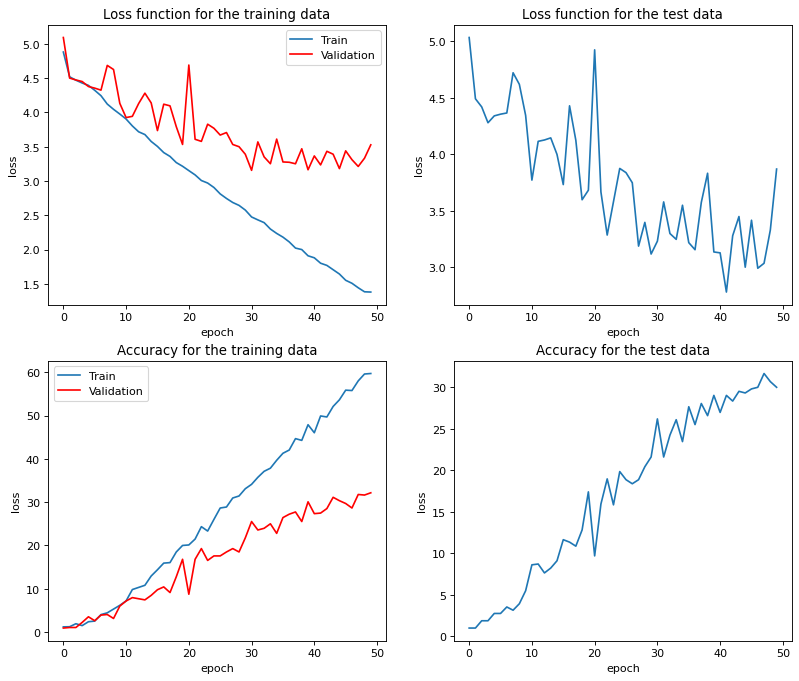

In [27]:
# plot train and val and test accuracy 
plt.figure(figsize=(12,10), dpi=80)

plt.subplot(2, 2, 1)
plt.plot(loss_train, label="Train")
plt.plot(loss_val, color='red', label="Validation")
plt.title('Loss function for the training data')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(loss_test)
plt.title('Loss function for the test data')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2, 2, 3)
plt.plot(accuracy_train, label="Train")
plt.plot(accuracy_val, color='red', label="Validation")
plt.title('Accuracy for the training data')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(accuracy_test)
plt.title('Accuracy for the test data')
plt.xlabel('epoch')
plt.ylabel('loss')

In [26]:
# save accuracy and loss
import pickle
with open("/kaggle/working/accuracy_shufflenet_v2_x1_0.txt", "wb") as fp:
    pickle.dump(accuracy_train, fp)
    pickle.dump(accuracy_val, fp)
    pickle.dump(accuracy_test, fp)

with open("/kaggle/working/loss_shufflenet_v2_x1_0.txt", "wb") as fp:
    pickle.dump(loss_train, fp)
    pickle.dump(loss_val, fp)
    pickle.dump(loss_test, fp)

# MobileNet V2

In [28]:
# Define the ShuflleNetV2 model
model = torchvision.models.mobilenet_v2(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 90)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(DEVICE)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [29]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [30]:
# Train phase
from tqdm import tqdm

# Define the number of epochs
num_epochs = 50
loss_train = []
loss_val = []
loss_test = []

accuracy_train = []
accuracy_val = []
accuracy_test = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss_train = 0.0
    correct_train = 0
    total_train = 0
    running_loss_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # loss
        running_loss_train += loss.item()
        # accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
    accuracy = 100 * correct_train / total_train
    loss_train.append(running_loss_train/len(train_loader))
    accuracy_train.append(accuracy)
    print(f"Accuracy of the network on the train images after {epoch + 1} epochs is: {accuracy}")

    # Evaluate the model on validation
    model.eval()
    correct_val = 0
    total_val = 0
    running_loss_val = 0
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs, val_labels = val_data
            val_inputs = val_inputs.to(DEVICE)
            val_labels = val_labels.to(DEVICE)
            # loss
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            running_loss_val += loss.item()
            # accuracy
            _, predicted_val = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()
    accuracy = 100 * correct_val / total_val
    loss_val.append(running_loss_val/len(val_loader))        
    accuracy_val.append(accuracy)
    print(f"Accuracy of the network on the val images after {epoch + 1} epochs is: {accuracy}")

    # Evaluate the model on test
    model.eval()
    correct_test = 0
    total_test = 0
    running_loss_test = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(val_outputs, val_labels)
            running_loss_test += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    accuracy = 100 * correct_test / total_test
    loss_test.append(running_loss_test/len(test_loader)) 
    accuracy_test.append(accuracy)
    print(f"Accuracy of the network on the test images after {epoch + 1} epochs is: {accuracy}")
    print('------------------------')

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy of the network on the train images after 1 epochs is: 1.3599537037037037
Accuracy of the network on the val images after 1 epochs is: 0.78125


  2%|▏         | 1/50 [02:08<1:44:39, 128.16s/it]

Accuracy of the network on the test images after 1 epochs is: 0.5859375
------------------------
Accuracy of the network on the train images after 2 epochs is: 2.372685185185185
Accuracy of the network on the val images after 2 epochs is: 3.3854166666666665


  4%|▍         | 2/50 [04:16<1:42:38, 128.29s/it]

Accuracy of the network on the test images after 2 epochs is: 3.90625
------------------------
Accuracy of the network on the train images after 3 epochs is: 4.224537037037037
Accuracy of the network on the val images after 3 epochs is: 2.6041666666666665


  6%|▌         | 3/50 [06:25<1:40:42, 128.55s/it]

Accuracy of the network on the test images after 3 epochs is: 3.41796875
------------------------
Accuracy of the network on the train images after 4 epochs is: 4.947916666666667
Accuracy of the network on the val images after 4 epochs is: 4.817708333333333


  8%|▊         | 4/50 [08:34<1:38:36, 128.62s/it]

Accuracy of the network on the test images after 4 epochs is: 4.296875
------------------------
Accuracy of the network on the train images after 5 epochs is: 5.063657407407407
Accuracy of the network on the val images after 5 epochs is: 2.9947916666666665


 10%|█         | 5/50 [10:42<1:36:31, 128.71s/it]

Accuracy of the network on the test images after 5 epochs is: 4.58984375
------------------------
Accuracy of the network on the train images after 6 epochs is: 5.439814814814815
Accuracy of the network on the val images after 6 epochs is: 4.947916666666667


 12%|█▏        | 6/50 [12:51<1:34:22, 128.69s/it]

Accuracy of the network on the test images after 6 epochs is: 6.25
------------------------
Accuracy of the network on the train images after 7 epochs is: 6.221064814814815
Accuracy of the network on the val images after 7 epochs is: 3.6458333333333335


 14%|█▍        | 7/50 [14:59<1:32:02, 128.44s/it]

Accuracy of the network on the test images after 7 epochs is: 4.78515625
------------------------
Accuracy of the network on the train images after 8 epochs is: 6.770833333333333
Accuracy of the network on the val images after 8 epochs is: 4.6875


 16%|█▌        | 8/50 [17:08<1:30:05, 128.71s/it]

Accuracy of the network on the test images after 8 epochs is: 4.98046875
------------------------
Accuracy of the network on the train images after 9 epochs is: 6.336805555555555
Accuracy of the network on the val images after 9 epochs is: 5.338541666666667


 18%|█▊        | 9/50 [19:17<1:28:00, 128.80s/it]

Accuracy of the network on the test images after 9 epochs is: 7.6171875
------------------------
Accuracy of the network on the train images after 10 epochs is: 6.626157407407407
Accuracy of the network on the val images after 10 epochs is: 7.8125


 20%|██        | 10/50 [21:27<1:26:06, 129.15s/it]

Accuracy of the network on the test images after 10 epochs is: 7.71484375
------------------------
Accuracy of the network on the train images after 11 epochs is: 7.320601851851852
Accuracy of the network on the val images after 11 epochs is: 5.598958333333333


 22%|██▏       | 11/50 [23:35<1:23:43, 128.81s/it]

Accuracy of the network on the test images after 11 epochs is: 5.17578125
------------------------
Accuracy of the network on the train images after 12 epochs is: 7.899305555555555
Accuracy of the network on the val images after 12 epochs is: 5.46875


 24%|██▍       | 12/50 [25:44<1:21:35, 128.82s/it]

Accuracy of the network on the test images after 12 epochs is: 5.859375
------------------------
Accuracy of the network on the train images after 13 epochs is: 8.333333333333334
Accuracy of the network on the val images after 13 epochs is: 5.859375


 26%|██▌       | 13/50 [27:52<1:19:17, 128.58s/it]

Accuracy of the network on the test images after 13 epochs is: 5.46875
------------------------
Accuracy of the network on the train images after 14 epochs is: 9.519675925925926
Accuracy of the network on the val images after 14 epochs is: 7.682291666666667


 28%|██▊       | 14/50 [30:03<1:17:32, 129.23s/it]

Accuracy of the network on the test images after 14 epochs is: 7.421875
------------------------
Accuracy of the network on the train images after 15 epochs is: 9.114583333333334
Accuracy of the network on the val images after 15 epochs is: 6.510416666666667


 30%|███       | 15/50 [32:13<1:15:30, 129.46s/it]

Accuracy of the network on the test images after 15 epochs is: 6.54296875
------------------------
Accuracy of the network on the train images after 16 epochs is: 9.635416666666666
Accuracy of the network on the val images after 16 epochs is: 4.6875


 32%|███▏      | 16/50 [34:22<1:13:14, 129.26s/it]

Accuracy of the network on the test images after 16 epochs is: 6.25
------------------------
Accuracy of the network on the train images after 17 epochs is: 9.924768518518519
Accuracy of the network on the val images after 17 epochs is: 8.072916666666666


 34%|███▍      | 17/50 [36:31<1:11:04, 129.23s/it]

Accuracy of the network on the test images after 17 epochs is: 8.30078125
------------------------
Accuracy of the network on the train images after 18 epochs is: 10.99537037037037
Accuracy of the network on the val images after 18 epochs is: 6.640625


 36%|███▌      | 18/50 [38:42<1:09:15, 129.87s/it]

Accuracy of the network on the test images after 18 epochs is: 8.10546875
------------------------
Accuracy of the network on the train images after 19 epochs is: 11.429398148148149
Accuracy of the network on the val images after 19 epochs is: 8.723958333333334


 38%|███▊      | 19/50 [40:53<1:07:13, 130.11s/it]

Accuracy of the network on the test images after 19 epochs is: 9.1796875
------------------------
Accuracy of the network on the train images after 20 epochs is: 12.094907407407407
Accuracy of the network on the val images after 20 epochs is: 7.942708333333333


 40%|████      | 20/50 [43:05<1:05:21, 130.70s/it]

Accuracy of the network on the test images after 20 epochs is: 6.640625
------------------------
Accuracy of the network on the train images after 21 epochs is: 12.210648148148149
Accuracy of the network on the val images after 21 epochs is: 8.723958333333334


 42%|████▏     | 21/50 [45:15<1:02:59, 130.34s/it]

Accuracy of the network on the test images after 21 epochs is: 9.5703125
------------------------
Accuracy of the network on the train images after 22 epochs is: 12.037037037037036
Accuracy of the network on the val images after 22 epochs is: 9.895833333333334


 44%|████▍     | 22/50 [47:25<1:00:52, 130.46s/it]

Accuracy of the network on the test images after 22 epochs is: 9.9609375
------------------------
Accuracy of the network on the train images after 23 epochs is: 11.71875
Accuracy of the network on the val images after 23 epochs is: 6.640625


 46%|████▌     | 23/50 [49:37<58:56, 130.99s/it]  

Accuracy of the network on the test images after 23 epochs is: 8.984375
------------------------
Accuracy of the network on the train images after 24 epochs is: 13.136574074074074
Accuracy of the network on the val images after 24 epochs is: 9.895833333333334


 48%|████▊     | 24/50 [51:47<56:30, 130.42s/it]

Accuracy of the network on the test images after 24 epochs is: 11.23046875
------------------------
Accuracy of the network on the train images after 25 epochs is: 13.310185185185185
Accuracy of the network on the val images after 25 epochs is: 9.375


 50%|█████     | 25/50 [53:57<54:19, 130.37s/it]

Accuracy of the network on the test images after 25 epochs is: 8.59375
------------------------
Accuracy of the network on the train images after 26 epochs is: 14.322916666666666
Accuracy of the network on the val images after 26 epochs is: 11.458333333333334


 52%|█████▏    | 26/50 [56:07<52:09, 130.40s/it]

Accuracy of the network on the test images after 26 epochs is: 11.71875
------------------------
Accuracy of the network on the train images after 27 epochs is: 13.773148148148149
Accuracy of the network on the val images after 27 epochs is: 10.286458333333334


 54%|█████▍    | 27/50 [58:17<49:55, 130.25s/it]

Accuracy of the network on the test images after 27 epochs is: 10.25390625
------------------------
Accuracy of the network on the train images after 28 epochs is: 16.087962962962962
Accuracy of the network on the val images after 28 epochs is: 13.151041666666666


 56%|█████▌    | 28/50 [1:00:27<47:42, 130.10s/it]

Accuracy of the network on the test images after 28 epochs is: 14.453125
------------------------
Accuracy of the network on the train images after 29 epochs is: 16.927083333333332
Accuracy of the network on the val images after 29 epochs is: 12.630208333333334


 58%|█████▊    | 29/50 [1:02:36<45:28, 129.92s/it]

Accuracy of the network on the test images after 29 epochs is: 12.6953125
------------------------
Accuracy of the network on the train images after 30 epochs is: 17.41898148148148
Accuracy of the network on the val images after 30 epochs is: 10.026041666666666


 60%|██████    | 30/50 [1:04:46<43:13, 129.67s/it]

Accuracy of the network on the test images after 30 epochs is: 8.10546875
------------------------
Accuracy of the network on the train images after 31 epochs is: 17.36111111111111
Accuracy of the network on the val images after 31 epochs is: 8.463541666666666


 62%|██████▏   | 31/50 [1:06:55<41:03, 129.67s/it]

Accuracy of the network on the test images after 31 epochs is: 11.9140625
------------------------
Accuracy of the network on the train images after 32 epochs is: 18.605324074074073
Accuracy of the network on the val images after 32 epochs is: 8.333333333333334


 64%|██████▍   | 32/50 [1:09:04<38:47, 129.30s/it]

Accuracy of the network on the test images after 32 epochs is: 8.3984375
------------------------
Accuracy of the network on the train images after 33 epochs is: 19.03935185185185
Accuracy of the network on the val images after 33 epochs is: 15.234375


 66%|██████▌   | 33/50 [1:11:14<36:44, 129.66s/it]

Accuracy of the network on the test images after 33 epochs is: 15.13671875
------------------------
Accuracy of the network on the train images after 34 epochs is: 20.13888888888889
Accuracy of the network on the val images after 34 epochs is: 11.71875


 68%|██████▊   | 34/50 [1:13:23<34:29, 129.36s/it]

Accuracy of the network on the test images after 34 epochs is: 14.35546875
------------------------
Accuracy of the network on the train images after 35 epochs is: 20.19675925925926
Accuracy of the network on the val images after 35 epochs is: 14.322916666666666


 70%|███████   | 35/50 [1:15:32<32:18, 129.23s/it]

Accuracy of the network on the test images after 35 epochs is: 16.6015625
------------------------
Accuracy of the network on the train images after 36 epochs is: 21.672453703703702
Accuracy of the network on the val images after 36 epochs is: 14.973958333333334


 72%|███████▏  | 36/50 [1:17:41<30:08, 129.16s/it]

Accuracy of the network on the test images after 36 epochs is: 15.8203125
------------------------
Accuracy of the network on the train images after 37 epochs is: 21.672453703703702
Accuracy of the network on the val images after 37 epochs is: 14.322916666666666


 74%|███████▍  | 37/50 [1:19:50<27:58, 129.14s/it]

Accuracy of the network on the test images after 37 epochs is: 17.48046875
------------------------
Accuracy of the network on the train images after 38 epochs is: 22.28009259259259
Accuracy of the network on the val images after 38 epochs is: 13.932291666666666


 76%|███████▌  | 38/50 [1:22:00<25:52, 129.41s/it]

Accuracy of the network on the test images after 38 epochs is: 15.72265625
------------------------
Accuracy of the network on the train images after 39 epochs is: 23.06134259259259
Accuracy of the network on the val images after 39 epochs is: 15.494791666666666


 78%|███████▊  | 39/50 [1:24:09<23:43, 129.36s/it]

Accuracy of the network on the test images after 39 epochs is: 17.578125
------------------------
Accuracy of the network on the train images after 40 epochs is: 23.958333333333332
Accuracy of the network on the val images after 40 epochs is: 15.104166666666666


 80%|████████  | 40/50 [1:26:20<21:36, 129.69s/it]

Accuracy of the network on the test images after 40 epochs is: 16.50390625
------------------------
Accuracy of the network on the train images after 41 epochs is: 25.578703703703702
Accuracy of the network on the val images after 41 epochs is: 15.755208333333334


 82%|████████▏ | 41/50 [1:28:29<19:25, 129.52s/it]

Accuracy of the network on the test images after 41 epochs is: 19.62890625
------------------------
Accuracy of the network on the train images after 42 epochs is: 26.27314814814815
Accuracy of the network on the val images after 42 epochs is: 17.1875


 84%|████████▍ | 42/50 [1:30:37<17:12, 129.05s/it]

Accuracy of the network on the test images after 42 epochs is: 18.06640625
------------------------
Accuracy of the network on the train images after 43 epochs is: 27.34375
Accuracy of the network on the val images after 43 epochs is: 16.666666666666668


 86%|████████▌ | 43/50 [1:32:46<15:04, 129.20s/it]

Accuracy of the network on the test images after 43 epochs is: 18.45703125
------------------------
Accuracy of the network on the train images after 44 epochs is: 27.864583333333332
Accuracy of the network on the val images after 44 epochs is: 17.578125


 88%|████████▊ | 44/50 [1:34:55<12:53, 128.95s/it]

Accuracy of the network on the test images after 44 epochs is: 15.33203125
------------------------
Accuracy of the network on the train images after 45 epochs is: 27.430555555555557
Accuracy of the network on the val images after 45 epochs is: 19.140625


 90%|█████████ | 45/50 [1:37:04<10:45, 129.05s/it]

Accuracy of the network on the test images after 45 epochs is: 20.3125
------------------------
Accuracy of the network on the train images after 46 epochs is: 29.39814814814815
Accuracy of the network on the val images after 46 epochs is: 19.010416666666668


 92%|█████████▏| 46/50 [1:39:13<08:36, 129.07s/it]

Accuracy of the network on the test images after 46 epochs is: 19.3359375
------------------------
Accuracy of the network on the train images after 47 epochs is: 29.484953703703702
Accuracy of the network on the val images after 47 epochs is: 16.666666666666668


 94%|█████████▍| 47/50 [1:41:22<06:26, 128.97s/it]

Accuracy of the network on the test images after 47 epochs is: 16.50390625
------------------------
Accuracy of the network on the train images after 48 epochs is: 30.324074074074073
Accuracy of the network on the val images after 48 epochs is: 17.057291666666668


 96%|█████████▌| 48/50 [1:43:30<04:17, 128.63s/it]

Accuracy of the network on the test images after 48 epochs is: 17.1875
------------------------
Accuracy of the network on the train images after 49 epochs is: 31.36574074074074
Accuracy of the network on the val images after 49 epochs is: 20.572916666666668


 98%|█████████▊| 49/50 [1:45:38<02:08, 128.67s/it]

Accuracy of the network on the test images after 49 epochs is: 20.1171875
------------------------
Accuracy of the network on the train images after 50 epochs is: 32.26273148148148
Accuracy of the network on the val images after 50 epochs is: 17.96875


100%|██████████| 50/50 [1:47:46<00:00, 129.34s/it]

Accuracy of the network on the test images after 50 epochs is: 19.921875
------------------------


In [31]:
#save the path
model_save_name = 'mobilenet_v2.pt'
path = f"/kaggle/working/{model_save_name}" 
torch.save(model.state_dict(), path)

Text(0, 0.5, 'loss')

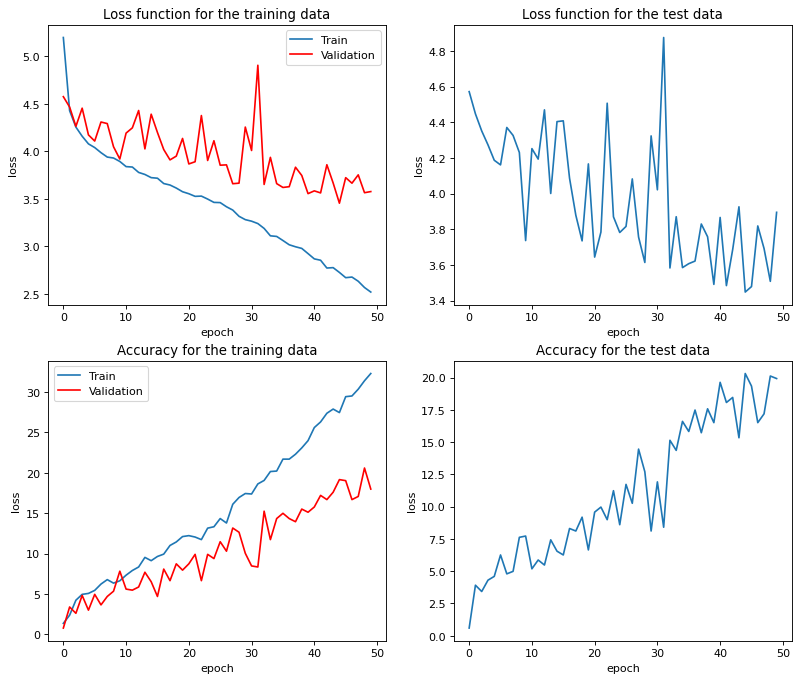

In [34]:
# plot train and val and test accuracy 
plt.figure(figsize=(12,10), dpi=80)

plt.subplot(2, 2, 1)
plt.plot(loss_train, label="Train")
plt.plot(loss_val, color='red', label="Validation")
plt.title('Loss function for the training data')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(loss_test)
plt.title('Loss function for the test data')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2, 2, 3)
plt.plot(accuracy_train, label="Train")
plt.plot(accuracy_val, color='red', label="Validation")
plt.title('Accuracy for the training data')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(accuracy_test)
plt.title('Accuracy for the test data')
plt.xlabel('epoch')
plt.ylabel('loss')

In [32]:
# save accuracy and loss
import pickle
with open("/kaggle/working/accuracy_mobilenet_v2.txt", "wb") as fp:
    pickle.dump(accuracy_train, fp)
    pickle.dump(accuracy_val, fp)
    pickle.dump(accuracy_test, fp)

with open("/kaggle/working/loss_mobilenet_v2.txt", "wb") as fp:
    pickle.dump(loss_train, fp)
    pickle.dump(loss_val, fp)
    pickle.dump(loss_test, fp)